In [1]:
import numpy as np
import os
# Polars is an alternative to Pandas. Experimentation!
import polars as pl
# An initial solution for generation
import sdv
from tqdm import tqdm

from sdv.evaluation import multi_table, single_table
from sdv.metadata import SingleTableMetadata, MultiTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.multi_table import HMASynthesizer

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
ad_data_orig = pl.scan_csv("data/train_data_ads.csv", infer_schema_length = 10000)
feed_data_orig = pl.scan_csv("data/train_data_feeds.csv", infer_schema_length = 10000)

In [3]:
# Convert `pt_d` to a datetime
ad_data = ad_data_orig.with_columns(
    pl.col("ad_click_list_v001").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("ad_click_list_v002").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("ad_click_list_v003").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_newsCatInterestsST").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("pt_d").cast(pl.String).str.to_datetime("%Y%m%d%H%M"),
)

In [4]:
feed_data = feed_data_orig.with_columns(
    pl.col("u_newsCatInterests").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_newsCatDislike").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_newsCatInterestsST").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_click_ca2_news").str.split("^").list.eval(pl.element().cast(pl.Int64)),
)
feed_data = feed_data.rename({ "u_userId": "user_id" })

In [5]:
ad_data.head().collect()

log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,list[i64],list[i64],list[i64],str,str,str,datetime[μs],list[i64],i64,i64
373250,0,100005,3,2,16,147,2,32,6,35,312,2117,7,14339,19319,6,1846,4,46,1,162,47,14,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373253,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373252,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373251,0,100005,3,2,16,147,2,32,6,35,312,2117,7,28665,20163,8,1542,4,47,1,152,49,17,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373255,0,100005,3,2,16,147,2,32,6,35,312,2117,7,34041,13608,8,1036,4,44,1,312,43,18,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:28:00,"[39, 220, 16]",0,15


In [6]:
feed_data.head().collect()

user_id,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST,u_click_ca2_news,i_docId,i_s_sourceId,i_regionEntity,i_cat,i_entities,i_dislikeTimes,i_upTimes,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro
i64,i64,i64,i64,i64,i64,list[i64],list[i64],list[i64],list[i64],str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""6e3e6bcb58d1fdd57b01a423f7a777…","""1eba881ea576fc05dfe457dd2111cd…",0,210,"""c7c6575e357e3e82c87fd04b04b28c…",4,1,13,19,1217,1,561,2,0,202206081521,-1,-1,0
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""f080276ae8aee56306253debbf643f…","""772b4a2593c3aa2590291f25d4bbc4…",0,219,"""40179dae61fecd7eaad86cdd128e70…",3,9,13,19,1217,9,561,1,0,202206081521,-1,-1,0
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""f6ee51f33fe8623b713a16287a873c…","""645e57afbbafce5159ab7fe956837c…",0,78,"""37d6e916f8c486d37683f03df3f578…",0,9,13,19,1217,18,561,1,0,202206081521,-1,-1,0
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""ee47079f7af99b70476161dbf5dcf0…","""9e5226ef81bf205dfe0ceefd6b7124…",1718,168,"""e36aff85ea6234ef8c68865db8abfc…",0,3,13,19,1217,7,561,1,1,202206081521,-1,-1,0
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""2363b609896dc2849cadf303a8d649…","""3a705744387ea91d68ce6b8172b528…",0,50,"""86d9e350f494a419533ebda912fd12…",9,9,13,19,1217,7,561,2,0,202206081522,-1,-1,0


In [7]:
# Aggregation: Age Group Demographics
ad_data.group_by(pl.col("age")).len().collect()

age,len
i64,u32
2,945971
6,912580
8,1622500
7,1544990
5,877423
9,137525
3,1460830
4,173698


In [8]:
ad_data.group_by(pl.col("age")).len().sort("age").collect().plot.bar(x = "age", y = "len")

:Bars   [age]   (len)

In [9]:
ad_data.group_by("user_id").agg(pl.count("age")).collect()

user_id,age
i64,u32
114736,30
210673,7
206886,471
253790,296
238326,38
…,…
269852,6
167782,115
267000,2


In [10]:
ad_data.select(pl.col("city")).collect().plot.hist()

:Histogram   [city]   (city_count)

In [11]:
ad_data.select(pl.col("device_name")).collect().plot.hist()

:Histogram   [device_name]   (device_name_count)

In [12]:
ad_data.select(pl.col("pt_d")).collect().plot.hist()

:Histogram   [pt_d]   (pt_d_count)

In [13]:
# Time of day
time_of_day = ad_data.select(pl.col("pt_d").dt.to_string("%H:%M").str.to_datetime("%H:%M").alias("time_of_day"))

In [14]:
time_of_day.collect().plot.hist()

:Histogram   [time_of_day]   (time_of_day_count)

In [15]:
feed_data_num = feed_data.select(pl.exclude([pl.List(pl.Float64), pl.List(pl.Int64), pl.String]))

In [16]:
feed_data_num.head().collect()
#pl.List?

user_id,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,i_regionEntity,i_cat,i_dislikeTimes,i_upTimes,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
135880,16,17,10,17,0,0,210,4,1,13,19,1217,1,561,2,0,202206081521,-1,-1,0
135880,16,17,10,17,0,0,219,3,9,13,19,1217,9,561,1,0,202206081521,-1,-1,0
135880,16,17,10,17,0,0,78,0,9,13,19,1217,18,561,1,0,202206081521,-1,-1,0
135880,16,17,10,17,0,1718,168,0,3,13,19,1217,7,561,1,1,202206081521,-1,-1,0
135880,16,17,10,17,0,0,50,9,9,13,19,1217,7,561,2,0,202206081522,-1,-1,0


In [17]:
feed_data_num.select(
    pl.corr(col_name, "label")
    for col_name in feed_data_num.columns
    if col_name != "label"
).collect().plot.bar()

:Bars   [index,Variable]   (value)

In [18]:
# This could also be done by using `any` instead of a random choice, using `unique` (if there are multiple, conflicting labels)
feed_data_uid_label = feed_data.select(pl.col("user_id"), pl.col("label")).unique(subset = ["user_id"])

In [19]:
feed_data_uid_label.head().collect()

user_id,label
i64,i64
285117,-1
164900,-1
187194,-1
200818,1
169893,-1


In [20]:
ad_data.count().collect()

log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517,7675517


In [21]:
ad_data_labeled = ad_data.join(feed_data_uid_label, how = "left", on = "user_id")

In [22]:
ad_data_labeled.head().collect()

log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle,label_right
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,list[i64],list[i64],list[i64],str,str,str,datetime[μs],list[i64],i64,i64,i64
373250,0,100005,3,2,16,147,2,32,6,35,312,2117,7,14339,19319,6,1846,4,46,1,162,47,14,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15,-1
373253,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15,-1
373252,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15,-1
373251,0,100005,3,2,16,147,2,32,6,35,312,2117,7,28665,20163,8,1542,4,47,1,152,49,17,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15,-1
373255,0,100005,3,2,16,147,2,32,6,35,312,2117,7,34041,13608,8,1036,4,44,1,312,43,18,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:28:00,"[39, 220, 16]",0,15,-1


In [23]:
ad_data_labeled_num = ad_data_labeled.select(
    pl.exclude([pl.List(pl.Float64), pl.List(pl.Int64), pl.String])
)

In [24]:
ad_data_labeled_num.select(
    pl.corr(col_name, "label_right")
    for col_name in ad_data_labeled_num.columns
    if col_name != "label_right"
).collect().plot.bar()

:Bars   [index,Variable]   (value)

In [25]:
feed_meta = SingleTableMetadata()
feed_meta.detect_from_csv(filepath = "data/train_data_feeds.csv")
feed_meta

{
    "columns": {
        "u_userId": {
            "sdtype": "numerical"
        },
        "u_phonePrice": {
            "sdtype": "categorical"
        },
        "u_browserLifeCycle": {
            "sdtype": "categorical"
        },
        "u_browserMode": {
            "sdtype": "categorical"
        },
        "u_feedLifeCycle": {
            "sdtype": "categorical"
        },
        "u_refreshTimes": {
            "sdtype": "categorical"
        },
        "u_newsCatInterests": {
            "sdtype": "categorical"
        },
        "u_newsCatDislike": {
            "sdtype": "categorical"
        },
        "u_newsCatInterestsST": {
            "sdtype": "categorical"
        },
        "u_click_ca2_news": {
            "sdtype": "unknown",
            "pii": true
        },
        "i_docId": {
            "sdtype": "categorical"
        },
        "i_s_sourceId": {
            "sdtype": "categorical"
        },
        "i_regionEntity": {
            "sdtype": "numerical"

In [26]:
# Save to JSON per recommendation from the package
if not os.path.exists("metadata_gen/feed_meta.json"):
    feed_meta.save_to_json("metadata_gen/feed_meta.json")

In [27]:
feed_synth = GaussianCopulaSynthesizer(feed_meta)

/home/sygio/Documents/work/ucla-hack/modeling/.venv/lib/python3.12/site-packages/sdv/single_table/base.py:84: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [28]:
feed_synth.fit(feed_data_orig.head(10000).collect().to_pandas())

In [29]:
feed_sample_data = feed_synth.sample(num_rows = 500)
feed_sample_data.head(10)

,u_userId,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST,u_click_ca2_news,...,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro
0,250515,11,17,14,17,9,168^102^219^191,0,219^98^78^98^17,sdv-pii-5l9f0,...,15,818,10,2366,2,0,202206081876,-1,-1,90
1,222015,14,17,14,17,5,98^98^78^0^98,0,98^98^218^147^213,sdv-pii-l4zm6,...,19,1233,5,1123,3,0,202206080588,-1,-1,88
2,267321,15,17,14,16,5,16^140^206^39^112,0,0,sdv-pii-odpgt,...,20,1439,8,651,2,1,202206082195,1,-1,100
3,210368,10,17,14,11,0,98^78^98^98^98,0,171^216^10^106^152,sdv-pii-n9fr8,...,20,170,3,829,2,0,202206081010,-1,-1,89
4,277446,14,17,14,17,9,86^191^96^36^98,0,216^195^59^166,sdv-pii-t6332,...,20,1241,11,1813,2,0,202206080148,1,-1,100
5,131187,15,17,14,17,5,16,0,216^49^98^63^219,sdv-pii-83dde,...,20,524,1,445,2,0,202206082048,-1,-1,100
6,272233,16,17,16,17,9,171^20^195^0^220,0,98,sdv-pii-51ctv,...,20,1258,10,2901,2,0,202206081103,-1,-1,87
7,160529,11,17,14,17,5,78^98^17^98^0,0,171^100^168^112^0,sdv-pii-ep6jr,...,20,258,5,2389,2,0,202206081667,-1,-1,77
8,117898,15,17,14,17,4,17^195^216^112^171,0,98^78^143^213^112,sdv-pii-80tu1,...,16,1229,5,694,6,1,202206081306,-1,-1,100
9,176243,14,17,16,17,0,65^63^65^65^0,0,219^171^218^51^17,sdv-pii-a65zp,...,20,812,22,2552,2,0,202206081189,-1,-1,100


In [30]:
single_table.run_diagnostic(
    real_data = feed_data_orig.head(10000).collect().to_pandas(),
    synthetic_data = feed_sample_data,
    metadata = feed_meta
)

Generating report ...

(1/2) Evaluating Data Validity: |███████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 781.23it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 419.77it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [31]:
feed_qual_report = single_table.evaluate_quality(
    feed_data_orig.head(10000).collect().to_pandas(),
    feed_sample_data,
    feed_meta,
)

Generating report ...

(1/2) Evaluating Column Shapes: |████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 39.25it/s]|
Column Shapes Score: 77.11%

(2/2) Evaluating Column Pair Trends: |█████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [03:57<00:00,  1.59it/s]|
Column Pair Trends Score: 57.26%

Overall Score (Average): 67.18%



In [32]:
feed_qual_report.get_details("Column Shapes")

,Column,Metric,Score
0,u_userId,KSComplement,0.957600
1,u_phonePrice,TVComplement,0.943100
2,u_browserLifeCycle,TVComplement,0.968500
3,u_browserMode,TVComplement,0.979100
4,u_feedLifeCycle,TVComplement,0.972800
5,u_refreshTimes,TVComplement,0.939200
6,u_newsCatInterests,TVComplement,0.540400
7,u_newsCatDislike,TVComplement,0.981900
8,u_newsCatInterestsST,TVComplement,0.380300
9,i_docId,TVComplement,0.313000


In [33]:
fig = single_table.get_column_plot(
    feed_data_orig.head(10000).collect().to_pandas(),
    feed_sample_data,
    feed_meta,
    "label",
)
fig.show()

In [34]:
fig = single_table.get_column_plot(
    feed_data_orig.head(10000).collect().to_pandas(),
    feed_sample_data,
    feed_meta,
    "i_regionEntity",
)
fig.show()

In [35]:
meta = MultiTableMetadata()
ad_df = ad_data_orig.head(10000).collect().to_pandas()
feed_df = feed_data_orig.head(10000).collect().to_pandas()
real_data = { "ad": ad_df, "feed": feed_df }
meta.detect_from_dataframes(
    data = {
        "ad": ad_df,
        "feed": feed_df,
    }
)

In [36]:
meta.update_columns(
    table_name = "ad",
    column_names = ["city", "city_rank"],
    sdtype = "numerical",
)

In [37]:
synth = HMASynthesizer(meta)
synth.fit(real_data)

/home/sygio/Documents/work/ucla-hack/modeling/.venv/lib/python3.12/site-packages/sdv/multi_table/base.py:87: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Preprocess Tables: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]



Learning relationships:



Modeling Tables: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.02s/it]


In [38]:
synth_data = synth.sample(scale = 1)

In [39]:
synth_data["ad"].head()

,log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,...,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle
0,655370077,0,101337,8,2,32,195,2,20,7,...,19117^10196^35062^30157^35991,2035^1690^1036^1502^1669,162^328^312,24107,1218,173,202206030139,194^140^76^188^51,8,17
1,688896014,0,101431,5,2,14,127,3,12,7,...,24075^24498^17926^30426^32776,1779,304^162^321^190,24107,1218,173,202206031028,78^25^86^44^67,4,17
2,654963116,0,100476,7,2,14,135,2,18,5,...,20974^15666^32675^26463,1653^1227^1036^2017,312^150^350^344^240,24107,1218,173,202206031077,98^98^29^39^121,5,17
3,680319117,0,100012,8,2,32,411,2,12,3,...,14737^25802^32492^13240^33873,1126^1037^1730^1719^1382,312^280^162^305^367,24107,1218,190,202206030232,98^78^168^8^0,0,17
4,600890133,0,100327,6,2,33,107,2,15,8,...,34515^29448^32895^10769^32842,1036^1216^1466^1717^1044,293,24107,1218,173,202206030154,0^67^0^0^199,4,11


In [40]:
multi_table.run_diagnostic(real_data, synth_data, meta)

Generating report ...

(1/3) Evaluating Data Validity: |███████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 730.68it/s]|
Data Validity Score: 100.0%

(2/3) Evaluating Data Structure: |████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 326.79it/s]|
Data Structure Score: 100.0%

(3/3) Evaluating Relationship Validity: |                                                                                                              | 0/0 [00:00<?, ?it/s]|
Relationship Validity Score: nan%

Overall Score (Average): 100.0%



In [41]:
qual_report = multi_table.evaluate_quality(real_data, synth_data, meta)

Generating report ...

(1/4) Evaluating Column Shapes: |███████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 185.07it/s]|
Column Shapes Score: 91.81%

(2/4) Evaluating Column Pair Trends: |█████████████████████████████████████████████████████████████████████████████████████████████████████| 973/973 [00:30<00:00, 31.52it/s]|
Column Pair Trends Score: 76.16%

(3/4) Evaluating Cardinality: |                                                                                                                        | 0/0 [00:00<?, ?it/s]|
Cardinality Score: nan%

(4/4) Evaluating Intertable Trends: |                                                                                                                  | 0/0 [00:00<?, ?it/s]|
Intertable Trends Score: nan%

Overall Score (Average): 83.99%



In [42]:
fig = multi_table.get_column_pair_plot(
    real_data = real_data,
    synthetic_data = synth_data,
    metadata = meta,
    table_name = "ad",
    column_names = ["label", "city"],
)
    
fig.show()

In [43]:
# Attempt :(
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [44]:
ad_data_uniq = ad_data.unique(subset = "user_id")
feed_data_uniq = feed_data.unique(subset = "user_id")

In [45]:
merged_uniq = ad_data_uniq.join(feed_data_uniq, on = "user_id", how = "left")

In [46]:
model = LogisticRegression()

In [47]:
merged_uniq.fetch()

log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle_right,u_refreshTimes_right,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST_right,u_click_ca2_news,i_docId,i_s_sourceId,i_regionEntity,i_cat,i_entities,i_dislikeTimes,i_upTimes,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label_right,cillabel,pro
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,list[i64],list[i64],list[i64],str,str,str,datetime[μs],list[i64],i64,i64,i64,i64,i64,i64,i64,list[i64],list[i64],list[i64],list[i64],str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
744753,0,100010,3,4,33,319,3,31,3,20,122,2117,7,26253,19329,8,1569,4,59,1,301,47,23,0.0,"[26498, 10137, 19181]","[1867, 1126, 1730]","[309, 305, 344]","""13770^19005^29823^10548^11284""","""1611^1499^1380^1669^1488""","""372^298^344^269^131""",2022-06-03 08:49:00,"[152, 112, … 109]",9,17,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
256617,0,100072,3,2,20,441,2,33,4,23,192,2301,6,29946,16847,8,1454,4,17,1,106,39,15,10.0,[31706],[1036],[312],"""24107""","""1218""","""173""",2022-06-03 08:46:00,"[86, 216, … 191]",8,17,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
332136,0,100063,3,2,20,383,2,19,6,30,228,1505,7,35264,20454,8,1173,5,47,1,162,47,14,10.0,"[19427, 36257, … 20072]","[1036, 1220, … 1126]","[312, 280, … 367]","""24107""","""1218""","""173""",2022-06-03 02:41:00,"[171, 65, … 112]",4,17,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
470246,0,100022,5,2,27,162,5,31,3,20,122,2519,7,31706,12646,8,1036,4,13,1,312,43,18,10.0,"[17020, 30157, … 28031]","[1036, 2066, … 1518]","[312, 114, … 152]","""24107""","""1218""","""173""",2022-06-03 07:37:00,"[98, 78, … 0]",6,17,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
373250,0,100005,3,2,16,147,2,32,6,35,312,2117,7,14339,19319,6,1846,4,46,1,162,47,14,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
101100,0,100006,5,2,13,191,4,32,6,20,229,1545,7,16972,20415,8,1690,5,28,1,213,18,23,0.0,"[28554, 22548, … 11623]","[1776, 1696, … 1886]","[219, 349, … 314]","""24107""","""1218""","""173""",2022-06-03 08:44:00,"[39, 78, … 16]",3,17,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
609957,0,100030,5,2,39,429,5,31,3,20,346,1269,7,16502,14798,10,1573,4,30,1,350,39,15,10.0,"[24055, 14747, … 31382]","[1112, 1245, … 1499]","[306, 116, … 141]","""24107""","""1218""","""173""",2022-06-03 12:52:00,"[98, 78, … 112]",9,17,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
576480,0,100024,5,2,32,179,5,34,7,19,260,2519,7,20464,16715,8,1041,5,38,1,246,47,23,0.0,"[14737, 25802, … 33873]","[1126, 1037, … 1382]","[305, 327, … 301]","""24107""","""1218""","""173""",2022-06-03 11:28:00,"[16, 173, … 65]",0,16,null,null,nul

In [48]:
feed_data_uniq.fetch()

user_id,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST,u_click_ca2_news,i_docId,i_s_sourceId,i_regionEntity,i_cat,i_entities,i_dislikeTimes,i_upTimes,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro
i64,i64,i64,i64,i64,i64,list[i64],list[i64],list[i64],list[i64],str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
116738,11,17,14,17,7,"[17, 104, … 25]",[0],"[143, 218, … 37]","[116, 143, … 96]","""e3e72d9208725ee85d3009122e003c…","""c79f10cf00438f227d16311908a4e5…",0,17,"""6d9658c7ccac05090158d597f8596b…",9,9,13,19,67,2,407,5,0,202206081920,-1,-1,0
252734,10,17,14,15,0,[168],[0],[0],"[168, 108]","""943452634f7a20cc54e07672d8446d…","""c79f10cf00438f227d16311908a4e5…",0,65,"""60f25a7b1e9648d57203114589f407…",1,9,13,19,705,7,2019,1,1,202206081921,-1,-1,0
243528,16,17,14,17,8,"[109, 199, … 16]",[0],"[131, 105, … 219]","[105, 147, … 205]","""a0296da4e2dd7bb41e7548e5d105a7…","""645e57afbbafce5159ab7fe956837c…",0,57,"""b66e6d4c97c2ad73d290a0c868cf8c…",3,9,11,19,1391,6,881,1,1,202206081118,-1,-1,0
278982,15,16,16,16,0,"[10, 98, … 220]",[0],[98],"[98, 207, … 74]","""f4a6941131d5ef178cf7adaad438b1…","""39c20be9cce448a7128ede705bc005…",0,98,"""820527373014c885a5e671ab7621f8…",1,7,13,19,335,7,2624,1,1,202206081628,-1,-1,0
248266,14,17,14,17,9,"[57, 199, … 131]",[0],"[56, 140, … 164]","[164, 56, … 140]","""23fb5672c1850d848d918121da0e87…","""14cbe3735e6fd61add145586131b3c…",2780,36,"""1d93c3dd07be1dba18114f1d7ceb46…",0,0,13,19,508,2,1220,2,0,202206082129,-1,-1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
281339,14,11,14,15,0,[0],[0],[219],[0],"""2d2e38f7899cc91a769bb157388912…","""9e5226ef81bf205dfe0ceefd6b7124…",0,219,"""40179dae61fecd7eaad86cdd128e70…",0,8,13,19,778,7,1930,1,1,202206081718,-1,-1,0
144492,16,17,14,17,8,"[168, 171, … 203]",[0],"[219, 44, … 49]","[219, 8, … 49]","""e2c0c992c08683f337959541221d19…","""1eba881ea576fc05dfe457dd2111cd…",0,171,"""ba0ced7622641c92240bf43725c651…",0,0,13,19,220,2,406,7,0,202206081721,-1,-1,0
193096,16,17,14,15,0,[0],[0],[0],[0],"""c3930b2460019d2d8aad65bc0f464f…","""772b4a2593c3aa2590291f25d4bbc4…",0,219,"""0c00d9fe62f1a3c36aa2e71463afbe…",0,9,11,19,1444,6,2593,1,1,202206081017,-1,-1,0


In [49]:
ad_user_ids = ad_data.select(pl.col("user_id")).unique().collect()

In [50]:
feed_cl = feed_data.with_columns([pl.col("user_id").is_in(ad_user_ids).alias("clicked").cast(pl.Int64)])

In [51]:
feed_cl.select(
    pl.corr(col_name, "clicked")
    for col_name, dtype in zip(feed_cl.columns, feed_cl.dtypes)
    if col_name != "clicked" and dtype != pl.List
).collect().plot.bar()

:Bars   [index,Variable]   (value)

In [52]:
feed_data.select(pl.col("label").value_counts()).collect()

label
struct[2]
"{-1,2911971}"
"{1,315761}"


In [53]:
rel_feed_cols = feed_cl.select([
    "label",
    "e_section",
    "e_rn",
    "i_upTimes",
    "i_dislikeTimes",
    "u_refreshTimes",
    "u_feedLifeCycle",
    "u_browserLifeCycle",
    "clicked",
])

data_cols = rel_feed_cols.collect()

In [54]:
train_df, test_df = train_test_split(data_cols)

In [55]:
train_X = train_df.select(pl.exclude("clicked"))
train_y = train_df.select(pl.col("clicked"))
test_X = test_df.select(pl.exclude("clicked"))
test_y = test_df.select(pl.col("clicked"))

In [56]:
test_y.select(pl.all().value_counts())

clicked
struct[2]
"{1,619136}"
"{0,187797}"


In [57]:
fit_model = model.fit(
    train_X,
    train_y["clicked"],
)

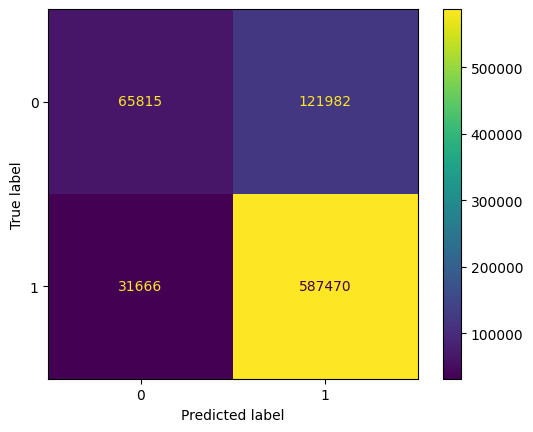

In [58]:
metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(test_y, model.predict(test_X))
).plot()

In [59]:
metrics.accuracy_score(test_y, model.predict(test_X))

0.8095901394539572

In [60]:
metrics.recall_score(test_y, model.predict(test_X))

0.9488545327682448

In [61]:
metrics.f1_score(test_y, model.predict(test_X))

0.8843524102280015

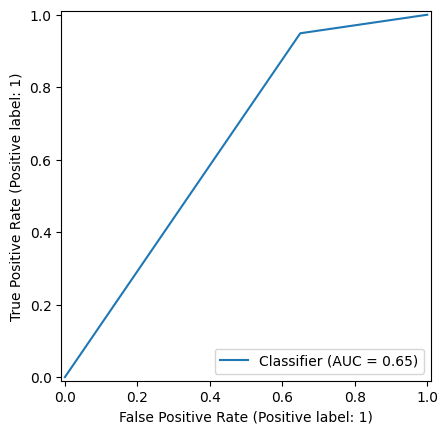

In [62]:
metrics.RocCurveDisplay.from_predictions(test_y, model.predict(test_X))